In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
import pandas as pd
import re
import os

# Load data from all experiments

In [2]:
def nested_dict():
    return defaultdict(nested_dict)

In [3]:
def get_model_type_from_filename(filename: str) -> str:
    if "sistence" in filename:
        return "GraphPersistence"
    
    elif "MLP" in filename:
        return "GraphMLP"
    
    elif "LSTM" in filename:
        return "GraphLSTM"
        
    elif "FFTransformer" in filename:
        return "GraphFFTransformer"
    
    else:
        raise AssertionError("No such model")

In [4]:
def get_forecast_horizon_from_filename(filename: str) -> str:
    horizon = re.findall(r'\d+', filename)[0]
    return f"{horizon}Step"


In [5]:
def extract_best_worst_nodes(metric_list, target_metric='mse_sc', n=3):
    node_metrics = defaultdict(dict)

    for item in metric_list:
        match = re.match(r'([a-z]+_sc)_(\d+):(.+)', item)
        if match:
            metric, node_id, value = match.groups()
            node_metrics[node_id][metric] = float(value)

    #only keep nodes that have the target metric
    filtered = {node: metrics for node, metrics in node_metrics.items() if target_metric in metrics}

    #sort by the target metric
    sorted_nodes = sorted(filtered.items(), key=lambda x: x[1][target_metric])

    #extract just the node IDs
    best_nodes = [(node,loss) for node, loss in sorted_nodes[:n]]
    worst_nodes = [(node,loss) for node, loss in sorted_nodes[-n:]]

    return best_nodes, worst_nodes

In [6]:
data = nested_dict()
base_dir = "../results/"
all_model_res_dirs = os.listdir(base_dir)
metric = "mse"
n=3

for model_res in all_model_res_dirs:
    
    forecast_horizon = get_forecast_horizon_from_filename(model_res)
    model_type = get_model_type_from_filename(model_res)
    model_itr = re.findall(r'\d+', model_res)[-1]
    
    if "sistence" not in model_type:
        with open(os.path.join(base_dir, model_res, "results_loss.txt"), "r") as f:
            all_model_result_data = f.read().strip().split()
            best, worst = extract_best_worst_nodes(all_model_result_data, target_metric=f"{metric}_sc", n=n)
            
        data[model_type][forecast_horizon][f"{model_itr}"][f"{metric}_loss"] = np.load(os.path.join(base_dir, model_res, "metrics.npy"))[1]
        data[model_type][forecast_horizon][f"{model_itr}"][f"{n}_best_node(s)"] = best[:n]#[:n]
        data[model_type][forecast_horizon][f"{model_itr}"][f"{n}_worst_node(s)"] = worst[:n]#[:n]
    else:
        data[model_type][forecast_horizon][f"{metric}_loss"] = np.load(os.path.join(base_dir, model_res, "metrics.npy"))[1]
    

data

defaultdict(<function __main__.nested_dict()>,
            {'GraphMLP': defaultdict(<function __main__.nested_dict()>,
                         {'1Step': defaultdict(<function __main__.nested_dict()>,
                                      {'0': defaultdict(<function __main__.nested_dict()>,
                                                   {'mse_loss': np.float32(0.10060299),
                                                    '3_best_node(s)': [('570715000000031304',
                                                      {'mae_sc': 0.16202398,
                                                       'mse_sc': 0.061135538,
                                                       'rmse_sc': 0.24725601,
                                                       'mape_sc': 1.2910581,
                                                       'mspe_sc': 435.25287}),
                                                     ('570715000000030888',
                                                      {'mae_s

# Extract best and worst prediction nodes across forecast horizons

In [7]:
model_of_interest = "GraphMLP" #GraphFFTransformer

In [8]:
# Initialize tracking dictionaries
tracking = {
    "1Step": {"best_loss": np.inf, "worst_loss": 0., "best_model": None, "worst_model": None},
    "4Step": {"best_loss": np.inf, "worst_loss": 0., "best_model": None, "worst_model": None},
    "24Step": {"best_loss": np.inf, "worst_loss": 0., "best_model": None, "worst_model": None}
}

# Iterate through models and metrics
for model, d1 in data.items():
    if model != model_of_interest:
        continue  # Only find the best and worst nodes for model of interest (could be all but persistent)

    for forecast_horizon, d2 in d1.items():
        if forecast_horizon not in tracking:
            continue  # Skip if forecast_horizon isn't one of the expected keys

        for itr, d3 in d2.items():
            best_node, best_loss = d3["3_best_node(s)"][0]
            worst_node, worst_loss = d3["3_worst_node(s)"][0]

            best_loss_val = best_loss[f"{metric}_sc"]
            worst_loss_val = worst_loss[f"{metric}_sc"]

            model_str_best = f"{forecast_horizon}_{model}_WindGraph_{itr}_{best_node}"
            model_str_worst = f"{forecast_horizon}_{model}_WindGraph_{itr}_{worst_node}"

            if best_loss_val <= tracking[forecast_horizon]["best_loss"]:
                tracking[forecast_horizon]["best_loss"] = best_loss_val
                tracking[forecast_horizon]["best_model"] = model_str_best

            if worst_loss_val >= tracking[forecast_horizon]["worst_loss"]:
                tracking[forecast_horizon]["worst_loss"] = worst_loss_val
                tracking[forecast_horizon]["worst_model"] = model_str_worst

# Output results
for time_step in ["1Step", "4Step", "24Step"]:
    print("worst model:", tracking[time_step]["worst_model"])
    print("best model:", tracking[time_step]["best_model"])
    print()
# print(tracking["24Step"]["worst_model"])
# print(tracking["24Step"]["best_model"])

worst model: 1Step_GraphMLP_WindGraph_3_570715000000083488
best model: 1Step_GraphMLP_WindGraph_2_570715000000031304

worst model: 4Step_GraphMLP_WindGraph_1_570715000000030383
best model: 4Step_GraphMLP_WindGraph_4_570715000000031304

worst model: 24Step_GraphMLP_WindGraph_4_570715000000030383
best model: 24Step_GraphMLP_WindGraph_3_570715000000031304



In [9]:
def match_model_str_to_model_filename(string: str, result_dir_path: str = "../results") -> tuple[str, str]:
    
    model_filenames = os.listdir(result_dir_path)
    
    #NOTE: 18 is the length of the node id (GSRN)
    model_info = string[:-18-1]
    node_id = string[-18:]
    
    prefix, suffix_number = model_info.rsplit('_', 1)
    
    match = [
        filename for filename in model_filenames 
        if filename.startswith(prefix) and filename.endswith(f"_{suffix_number}")
        ][0]
    
    return match, node_id

match_model_str_to_model_filename(tracking["4Step"]["best_model"])
    

('4Step_GraphMLP_WindGraph_ftM_sl24_ll24_pl4_4', '570715000000031304')

In [14]:
def get_values_of_specific_model_and_node(model_name: str,
                                          node_id: str,
                                          base_dir: str = "../results/"
                                          ) -> tuple[np.ndarray, np.ndarray]:
    
    model_path = os.path.join(base_dir, model_name)
    
    preds_unscaled = np.load(os.path.join(model_path, "pred_un.npy"))
    trues_unscaled = np.load(os.path.join(model_path, "true_un.npy"))
    turbines = np.load(os.path.join(model_path, "station_ids.npy"))
    
    turbine_ids = np.where(turbines == node_id)
    
    preds_of_interest = preds_unscaled[turbine_ids].squeeze(-1)
    trues_of_interest = trues_unscaled[turbine_ids].squeeze(-1)
    
    return preds_of_interest, trues_of_interest


p, t = get_values_of_specific_model_and_node(model_name="4Step_GraphMLP_WindGraph_ftM_sl24_ll24_pl4_4",
                                             node_id="570715000000031304")

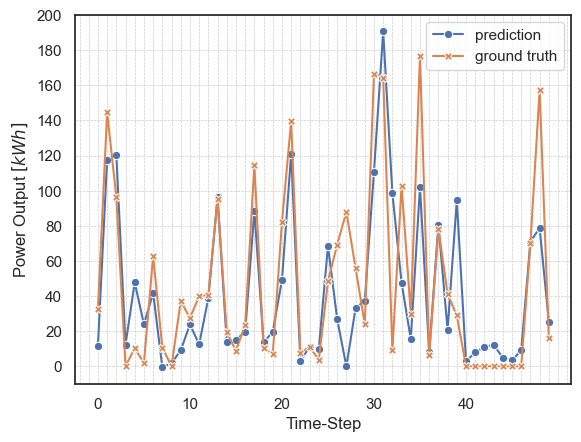

In [17]:



pds = []
gts = []
for i in range(p.shape[0]):
    pds.append(p[i, -1])
    gts.append(t[i, -1])


n = 50

# Create DataFrame in long format
df = pd.DataFrame({
    "timestep": list(range(n)) * 2,
    "value": pds[:n] + gts[:n],
    "type": ["prediction"] * n + ["ground truth"] * n
})

# Plot
sns.lineplot(data=df, 
             x="timestep",
             y="value",
             hue="type",
             style="type",
             markers=True,
             dashes=False)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, title=None)

#plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(0, max(df["timestep"]) + 1, 10))  # Label every 10 steps
ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))  # Grid every 4 steps
ax.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)  # Grid at major ticks
ax.grid(True, which='minor', axis='x', linestyle='--', linewidth=0.5)

ax.yaxis.set_major_locator(ticker.MultipleLocator(20))   # Optional: set major y-ticks
ax.yaxis.set_minor_locator(ticker.MultipleLocator(4))    # Optional: finer grid
ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)


plt.xlabel("Time-Step")
plt.ylabel("Power Output $[kWh]$")
plt.show()

# Inspect model performance across forecast horizons

In [12]:
records = []
for model, model_data in data.items():
    if model == 'GraphPersistence':
        continue
    
    for horizon_str, losses in model_data.items():
        horizon = int(horizon_str.replace('Step', ''))
        persistence_loss = data['GraphPersistence'][horizon_str]['mse_loss']
        
        for itr, d in losses.items():
            
            mse = d["mse_loss"]
            mse_ratio = mse / persistence_loss
            
            records.append({
                "model" : model,
                "horizon" : horizon,
                "run" : itr,
                "mse_ratio" : mse_ratio
            })
            

df2 = pd.DataFrame(records)

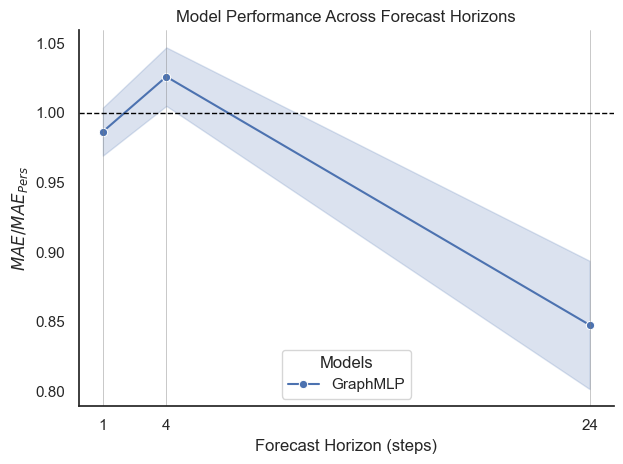

In [13]:

sns.set_theme(style="white")

    
sns.lineplot(data=df2,
             x="horizon",
             y="mse_ratio",
             hue="model",
             style="model",
             errorbar="sd",
             err_style="band",
             markers=True,
             dashes=False)

horizons = [1, 4, 24]
for horizon in horizons:
    plt.axvline(x=horizon, color="gray", linestyle="-", linewidth=0.5, alpha=0.6)


sns.despine()
plt.xticks(horizons)


plt.axhline(1.0, color="black", linestyle="--", linewidth=1)  # Persistence baseline
plt.title("Model Performance Across Forecast Horizons")
plt.ylabel(r"$MAE / MAE_{Pers}$")
plt.xlabel("Forecast Horizon (steps)")
plt.legend(title="Models")
plt.tight_layout()
plt.show()

In [ ]:
data